# CS-E4895: Gaussian Processes (2023)

# Lab exercise #4: Sparse GPs, RKHS, Infinitely wide neural nets

# Task 1: Sparse variational GPs & Whitening (worth 2 points)

In this task, we implement the sparse GP version of the GP classification task in the previous assignment. Sparse GPs allow us to scale the GP inference to much larger data sets by using *inducing points*. We will use the same data set as last time, but this time the full version with >5000 data points. This would be very computationally demanding with the non-sparse approach. 

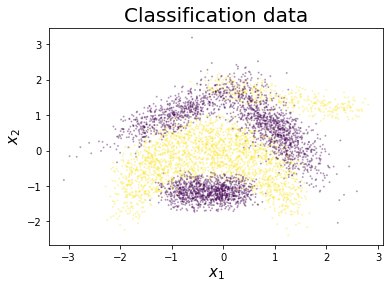

In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

# Loading the data

import csv
XY = []
with open("banana.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        XY.append(row)
XY = np.array(XY)
X = XY[:,:2]
Y = (XY[:,2:3]-1.5) * 2 # to be in {-1, 1}
N = XY.shape[0]

# Plotting the data

plt.scatter(X[:,0], X[:,1], c=Y, s=1, alpha=0.3)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('Classification data', fontsize=20);

In [2]:
def KL(m0, L0, m1, L1):
    """ returns the KL divergence between N(m0, S0) and N(m1, S1)
    
    arguments:
    m0, m1   -- N × 1, mean vector
    L0, L1   -- N × N, Cholesky factor of a covariance matrix 
    returns a scalar
    """
    term1 = tf.reduce_sum(tf.square(tf.linalg.solve(L1, L0)))
    term2 = tf.reduce_sum(tf.square(tf.linalg.solve(L1, (m1-m0))))
    k = tf.cast(tf.shape(L0)[0], tf.float64)
    term3inner = tf.math.log(tf.abs(tf.linalg.diag_part(L1))) - tf.math.log(tf.abs(tf.linalg.diag_part(L0)))
    return 0.5 * (term1 + term2 - k + 2 * tf.reduce_sum(term3inner))

    #################################################
    # ------- copy-paste code here from last time ---
    #################################################

def q_marginals(m, L):
    """ returns the vectors of marginal means and marginal variances
    i.e, the means and variances of q(f_n)
    
    Hint: To implement this really efficiently, you don't have to calculate the entire covariance matrix
    
    arguments:
    m   -- N × 1, mean vector
    L   -- N × N, Cholesky factor of a covariance matrix 
    returns two N × 1 vectors
    """
    v = tf.reshape(tf.linalg.diag_part(tf.matmul(L, L, transpose_b = True)), (-1, 1))
    return m, v

    #################################################
    # ------- copy-paste code here from last time ---
    #################################################

def phi(x):
    r""" Cumulative distribution function for the standard normal distribution 
    Hint: you may want to use the error function. (tf.math.erf if using tensorflow)
    Hint 2: You may want to use a small epsilon parameter to ensure that the output 
            is strictly between 0 and 1

    phi(x) = int_{-\infty, x} N(u| 0, 1) du    
    """
    #################################################
    # ------- copy-paste code here from last time ---
    #################################################
    jitter= 1e-3
    return 0.5 * (1.0 + tf.math.erf(x/np.sqrt(2))) * (1- 2 * jitter) + jitter

def classif_log_likelihood(f, y):
    """ log p(y|f) for classification using the normal cdf 
        log p(y|f) = log phi(y * f)
        
    Arguments:
    f -- The GP value at the observation
    y -- The observed value of y, either -1 or 1
    """
    #################################################
    # ------- copy-paste code here from last time ---
    #################################################
    return tf.math.log(phi(f * y))

def expected_log_likelihood(
    means, mvars, llh, y, n_gh=20):
    """ returns the expected log likelihood terms
    
    E_q(f_n)[log p(y_n|f_n)]
    
    This is a quadrature approximation, 
    turning the integral into a sum.
        
    arguments:
    means  -- N × 1, vector of means
    mvars  -- N × 1, vector of marginal variances
    llh    -- log likelihood function
    y      -- N × 1, vector of observed labels
    """
    z, dz = np.polynomial.hermite.hermgauss(n_gh)
    weights = (dz / np.sqrt(np.pi)).reshape(1, -1) # 1 × n_gh
    inputs = means + np.sqrt(2) * tf.sqrt(mvars) * z.reshape(1, -1) # N × n_gh
    llh_quad = weights * llh(inputs, y) # N × n_gh

    return tf.reduce_sum(llh_quad, axis=1) # N,

def kernelmatrix(X1, X2, log_ell, log_sigma_squared):
    ell = tf.exp(log_ell)
    sigma_squared = tf.exp(log_sigma_squared)
    dist = tf.reduce_sum((X1[:, None, :] - X2[None, :, :])**2, axis=-1)
    kernel_matrix = sigma_squared * tf.exp(-dist / (ell**2))
    return kernel_matrix

def kernelmatrix_diagonal(X, log_sigma_squared):
    sigma_squared = tf.exp(log_sigma_squared)
    return sigma_squared * np.ones((len(X), 1))

def posterior_marginal_prediction(X_new, X, m_q, L_q, log_ell, log_sigma_squared):
    """ compute the posterior marginal predictions q(f(x*)) 
    independently for all inputs in X_new 
    
    Note: You need to now use tensorflow functions.
    
    arguments:
    X_new -- N_new × 2, matrix of new inputs
    X     -- N × 2, matrix of training inputs
    m_q   -- N × 1, mean vector of q
    L_q   -- N × N, Cholesky factor of the covariances of q
    log_ell -- log-length-scale of the kernel
    log_sigma_squared -- log-variance of the kernel
    returns: predictive marginal means and variances (both with size N_new × 1)
    """

    #################################################
    # ------- copy-paste code here from last time ---
    #################################################
    ### IMPORTANT
    # We should avoid computing the full N_new × N_new covariance matrix due to memory limitations.
    # You only need the diagonal values of this matrix for the predictive variances.
    # Could you implement an alternative to kernelmatrix() to do this?
    ### NEW IMPORTANT NOTE
    # Last time you may have gotten this to work without using tensorflow functions. 
    # Now you really need them because we are going to calculate gradients through this function

    Kfs = kernelmatrix(X, X_new, log_ell, log_sigma_squared)
    Kff = kernelmatrix(X, X, log_ell, log_sigma_squared)
    Kss = kernelmatrix_diagonal(X_new, log_sigma_squared)
    KffInv_Kfs = tf.linalg.solve(Kff, Kfs)
    m = tf.matmul(KffInv_Kfs, m_q, transpose_a = True)
    S = tf.matmul(L_q, L_q, transpose_b = True)
    v = Kss - tf.reduce_sum(KffInv_Kfs * ((Kff - S) @ KffInv_Kfs), axis=0)[:, None]
    
    return m, v

# Sparse GP ELBO
To evaluate the variational expectations (data fit) term of the SVGP (Stochastic variational GP) objective, you need the marginals of $q({\bf f})$ - think about how you can re-use `posterior_marginal_prediction` for that. 

In [3]:
def sparse_gp_elbo(m_p, L_p, m_q, L_q, Z, X, y, log_ell, log_sigma_squared):
    """ returns ELBO
    ℒ = ∑ₙ₌₁ᴺ 𝔼_q(fₙ)[log p(yₙ|fₙ)] - KL[q(u)∥p(u)]
    
    (See slides of lecture 5 and 6 for closed-form solution)
    
    arguments:
    L_p, L_q  -- N × N, Cholesky factors of the covariances of p and q
    m_p, m_q  -- N × 1, mean vector of p and q
    Z, X      -- N × D, inducing points and training points
    y         -- N × 1, training observations
    log_ell   -- log length scale
    log_sigma_squared -- log kernel variance
    returns: a scalar
    """ 
    # MODEL SOLUTION #
    marginal_mean, marginal_variance = posterior_marginal_prediction(X, Z, m_q, L_q, log_ell, log_sigma_squared)
    VE = tf.reduce_sum(expected_log_likelihood(marginal_mean, marginal_variance, classif_log_likelihood, y, n_gh=20))
    KL_div = KL(m_q, L_q, m_p, L_p)
    return VE - KL_div
    ###############################################
    # ------- insert code here -------------------
    ###############################################

# Whitened sparse GP ELBO
In the code below, let's also implement 'whitening': Instead of parametrizing the Cholesky factor of the posterior covariance directly, we define a new variable $\mathbf v$ such that $\mathbf u = \mathbf L_p \mathbf v + \mathbf m_p$, where $\mathbf u$ are the inducing variables. The reason is that the optimization pushes $q(\mathbf u)$ to be similar to $p(\mathbf u)$, and thus the elements in $\mathbf L_q$ are strongly correlated. This makes optimization more difficult. In contrast, the distribution of $\mathbf v$ that corresponds to the prior is $\mathcal N(\mathbf 0, \mathbf I)$. Thus, we define our optimized variables as $\mathbf m', \mathbf S'$ in $q(\mathbf v) = \mathcal N(\mathbf m', \mathbf S')$ and transform them back to $\mathbf u$-space using $L_p, m_p$ whenever we need to do ELBO calculations or calculate conditional distributions. When we do this, $\mathbf m'$ and $\mathbf S'$ are much easier to optimize than directly defining them as the mean and covariance of the real posterior $q(\mathbf u)$.

See also lecture 7. 

In [4]:
def unwhiten(m_p, L_p, m_qv, L_qv):
    """Transformation from the whitened distribution q(v) to unwhitened distribution q(u)
    arguments:
    L_p, L_qv  -- N × N, Cholesky factors of the covariances of p and the whitened q
    m_p, m_qv  -- N × 1, mean vector of p and the whitened q
    returns:
    m_qu       -- N × 1 unwhitened mean vector and NxN
    L_qu       -- N x N Cholesky factor of the unwhitened covariance
    """
    # https://en.wikipedia.org/wiki/Whitening_transformation
    # q(v) has prior N(0, I) and L_qv is only nonzero on diagonal
    
    # Whitening: reparameterization
    # Define u = Lv(+prior mean)
    # where L = chol(K) or K = LL⊤
    # Prior p(v) = N (0, I), completely uncorrelated
    # Optimize over q(v) = N (m′, S′) instead
    # Approximate posterior q(u) = N (Lm′, LS′L^T)
    
    # q(v) is whitened and q(v) = N(m', S') => m_qv = m' and L_qv * L_qv^T = S'
    # q(u) is unwhitened and q(u) = N(Lm', LS'L^T) => m_qu = L_p * m' and L_qu * L_qu.T = L_p * S' * L_p^T
    # => L_qu * L_qu.T = L_p * L_qv * L_qv^T * L_p^T
    # => m_qu = L_p * m_qv + m_p
    
    # compute the inverse of the Cholesky factor of p
    
    # MODEL SOLUTION
    S_qu = L_p @ L_qv @ tf.matmul(L_qv, L_p, transpose_a=True, transpose_b=True)
    L_qu = tf.linalg.cholesky(S_qu) 
    #L_qu = L_p @ L_qv

    m_qu = L_p @ m_qv + m_p

    return m_qu, L_qu
    
    # slide 62
    ###############################################
    # ------- insert code here -------------------
    ###############################################

def sparse_gp_elbo_whitened(m_p, L_p, m_qv, L_qv, Z, X, y, log_ell, log_sigma_squared):
    # TODO: Redefine these variables to make more sense!
    """ returns ELBO
    ℒ = ∑ₙ₌₁ᴺ 𝔼_q(fₙ)[log p(yₙ|fₙ)] - KL[q(v)∥p(v)]
    
    (See slides of lecture 5 and 6 for closed-form solution)
    
    arguments:
    L_p, L_qv  -- N × N, Cholesky factors of the covariances of p and the whitened q
    m_p, m_qv  -- N × 1, mean vector of p and the whitened q
    Z, X      -- N × D, inducing points and training points
    y         -- N × 1, training observations
    returns: a scalar
    """
    # Model solution
    m_qu, L_qu = unwhiten(m_p, L_p, m_qv, L_qv)
    elbo = sparse_gp_elbo(m_p, L_p, m_qu, L_qu, Z, X, y, log_ell, log_sigma_squared)

    return elbo
    
    # Combined two functions above
    ###############################################
    # ------- insert code here -------------------
    ###############################################

# Running the optimisation
Use the following code to run the variational inference optimisation loop. Get to know the code, and answer the following questions about it:

- How many inducing points are we using? 
- To what values are they initialised in the code?

Let's not optimise the hyperparameters now for simplicity. If you like, you can try modifying the code to also optimise them.

In [5]:
def optimize_elbo(ell, sigma_squared, optimize_inducing_points=False):
    # kernel parameters
    ell = 0.5  # the length scale
    sigma_squared = 3.0**2  # the kernel variance

    # Log-hyperparameters:
    v_log_ell = tf.Variable(np.log(ell), dtype=tf.float64)
    v_log_sigma_squared = tf.Variable(np.log(sigma_squared), dtype=tf.float64)

    M = 16
    Z = tf.Variable(X[:M].copy())
    print("Shape of Z:", Z.shape)
    print("Z is")
    print(Z)
    
    # The prior mean at the inducing points and the Cholesky factor of the prior covariance, with small diagonal jitter
    K_p = kernelmatrix(Z, Z, v_log_ell, v_log_sigma_squared) + 1e-10*np.eye(M)
    m_p = tf.zeros((M, 1), dtype=tf.float64)
    L_p = tf.linalg.cholesky(K_p)

    # Inference distributions
    m_qv = tf.Variable(np.zeros((M, 1)), dtype=tf.float64)
    L_qv_params = tf.Variable(tfp.math.fill_triangular_inverse(np.zeros((M,M))), dtype=tf.float64)
    filltriangular = tfp.bijectors.FillTriangular(upper=False)
    positivediagonal = tfp.bijectors.TransformDiagonal(diag_bijector=tfp.bijectors.Exp())
    transform = lambda x: positivediagonal(filltriangular(x))

    loss_svgp = lambda: - sparse_gp_elbo_whitened(
        m_p, tf.linalg.cholesky(kernelmatrix(Z, Z, v_log_ell, v_log_sigma_squared)+ 1e-10*tf.eye(Z.shape[0],dtype=tf.float64)),
        m_qv, transform(L_qv_params), Z, X, Y, v_log_ell, v_log_sigma_squared)

    ##### definition of a training step
    def create_train_step(loss, opt, trainable_variables):
        @tf.function  # this makes the optimisation loop much faster, but restricts what operations you can do within your code
        def train_step():
            with tf.GradientTape() as tape:
                tape.watch(trainable_variables)
                loss_value = loss()
            gradients = tape.gradient(loss_value, trainable_variables)
            opt.apply_gradients(zip(gradients, trainable_variables))
            return loss_value
        return train_step

    # you can change the optimizer or learning rate
    opt = tf.optimizers.Adam(learning_rate=0.1)
    train_step = create_train_step(loss_svgp, opt, [Z, m_qv, L_qv_params]) if optimize_inducing_points \
                                        else create_train_step(loss_svgp, opt, [m_qv, L_qv_params])

    num_iterations = 1100 # you can change the number of steps as well

    # running the optimization
    neg_elbo_values = []
    for t in range(num_iterations):
        neg_elbo_value = train_step()
        neg_elbo_values.append(neg_elbo_value)
        if t % 500 == 0:
            print(t, loss_svgp().numpy())
    return Z, m_qv, transform(L_qv_params), neg_elbo_values

In [6]:
# kernel parameters
ell = 0.5  # the length scale
sigma_squared = 3.0**2  # the kernel variance
Z, m_qv, L_qv, neg_elbo_values = optimize_elbo(ell, sigma_squared, optimize_inducing_points=False)

Shape of Z: (16, 2)
Z is
<tf.Variable 'Variable:0' shape=(16, 2) dtype=float64, numpy=
array([[ 1.14  , -0.114 ],
       [-1.52  , -1.15  ],
       [-1.05  ,  0.72  ],
       [-0.916 ,  0.397 ],
       [-1.09  ,  0.437 ],
       [-0.584 ,  0.0937],
       [ 1.83  ,  0.452 ],
       [-1.25  , -0.286 ],
       [ 1.7   ,  1.21  ],
       [-0.482 , -0.485 ],
       [ 1.79  , -0.459 ],
       [-0.122 , -0.808 ],
       [ 0.0809,  1.93  ],
       [-0.541 , -0.332 ],
       [-1.02  ,  0.619 ],
       [-0.768 , -1.04  ]])>
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0 10400.108647348141
500 5227.280943879867
1000 5226.100686639243


- How many inducing points are we using? 

We are using 16 inducing points Z

- To what values are they initialised in the code?

They are initialized with the first existing 16 X datapoints


## Optimisation with fixed inducing points & plotting results
First, let's try optimising the ELBO only with the mean and covariance of $q(\mathbf u)$, and keep the inducing point locations $\mathbf Z$ fixed at a subset of data points. 

After finding the parameters $\mathbf L_q$ and $\mathbf m_q$, plot the results using the function provided. Note that the optimisation loop returns the whitened $\mathbf L_q$ and $\mathbf m_q$, you will have to take that into account before passing values to the plotting code.

Also copy-paste your solution from last week for the posterior predictive distribution $p(y*=1|y)$ in the plotting code. 

Shape of Z: (16, 2)
Z is
<tf.Variable 'Variable:0' shape=(16, 2) dtype=float64, numpy=
array([[ 1.14  , -0.114 ],
       [-1.52  , -1.15  ],
       [-1.05  ,  0.72  ],
       [-0.916 ,  0.397 ],
       [-1.09  ,  0.437 ],
       [-0.584 ,  0.0937],
       [ 1.83  ,  0.452 ],
       [-1.25  , -0.286 ],
       [ 1.7   ,  1.21  ],
       [-0.482 , -0.485 ],
       [ 1.79  , -0.459 ],
       [-0.122 , -0.808 ],
       [ 0.0809,  1.93  ],
       [-0.541 , -0.332 ],
       [-1.02  ,  0.619 ],
       [-0.768 , -1.04  ]])>
0 10400.108647348141
500 5227.280943879867
1000 5226.100686639243


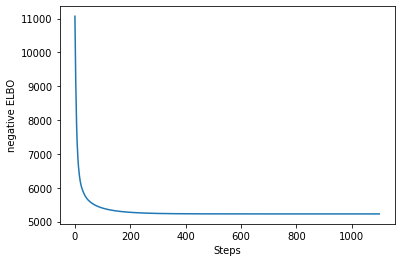

In [7]:
# kernel parameters
ell = 0.5  # the length scale
sigma_squared = 3.0**2  # the kernel variance
Z, m_qv, L_qv, neg_elbo_values = optimize_elbo(ell, sigma_squared, optimize_inducing_points=False)
plt.plot(neg_elbo_values)
plt.ylabel('negative ELBO')
plt.xlabel('Steps')
plt.show()

In [9]:
# create new input points on grid
n_grid = 100
x = np.linspace(XY[:,0].min(), XY[:,1].max(), n_grid)
X1new, X2new = np.meshgrid(x, x)
Xnew = np.hstack([
  X1new.reshape(-1,1), X2new.reshape(-1,1)
])  # size : n_grid * n_grid x 2

In [10]:
def plot_posterior(Z, m_new, v_new, neg_elbo_values):
    """
    Plots the posterior prediction for the grid in Xnew (global variable)
    
    arguments:
    m_new -- mean at Xnew
    v_new -- variance at Xnew
    """
    # first, compute marginal posterior over y from the posterior over f:
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    # analytical solution (closed form)
    # y_new = phi(m_new/tf.sqrt(1+v_new))
    # numerical solution
    y_new = expected_log_likelihood(m_new, v_new, lambda f, _: phi(f), None)[:, None]
    
    plt.figure(figsize=(12,4))
    plt.suptitle(f"ELBO: {-neg_elbo_values[-1] : .2f}")
    plt.subplot(1,3,1)
    plt.contour(x, x, m_new.numpy().reshape(n_grid,n_grid),
                cmap=plt.cm.RdBu_r, vmin=-np.abs(m_new).max(), vmax=np.abs(m_new).max())
    plt.colorbar()
    plt.title("Posterior mean")
    plt.subplot(1,3,2)
    plt.contour(x, x, v_new.numpy().reshape(n_grid,n_grid))
    plt.colorbar()
    plt.title("Posterior variance")
    plt.subplot(1,3,3)
    plt.scatter(Z[:,0], Z[:,1], color='black') # Inducing points
    plt.legend(["Inducing points"])
    plt.contour(x, x, y_new.numpy().reshape(n_grid,n_grid),
                cmap=plt.cm.RdBu_r, vmin=0, vmax=1)
    plt.colorbar()
    plt.title("p(y|f)")

    plt.scatter(X[:,0], X[:,1], c=Y, s=1, alpha=0.3)  # all data points
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())

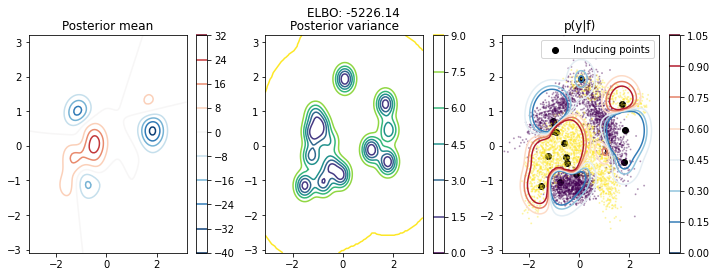

In [11]:
###############################################
# ------- insert code here -------------------
###############################################
# Note: The m_qv and L_qv are whitened posterior parameters

# Model solution

# Log-hyperparameters:
v_log_ell = tf.Variable(np.log(ell), dtype=tf.float64)
v_log_sigma_squared = tf.Variable(np.log(sigma_squared), dtype=tf.float64)

M = 16
Z = tf.Variable(X[:M].copy())

# The prior mean at the inducing points and the Cholesky factor of the prior covariance, with small diagonal jitter
K_p = kernelmatrix(Z, Z, v_log_ell, v_log_sigma_squared) + 1e-10*np.eye(M)
m_p = tf.zeros((M, 1), dtype=tf.float64)
L_p = tf.linalg.cholesky(K_p)

m_qu, L_qu = unwhiten(m_p, L_p, m_qv, L_qv)
m_new, v_new = posterior_marginal_prediction(Xnew, Z, m_qu, L_qu, v_log_ell, v_log_sigma_squared)

plot_posterior(Z, m_new, v_new, neg_elbo_values)

## Optimisation of the inducing points as well & plot results
Next, try optimising the inducing points as well with the code below, and plot the results. Are the results any different?

Shape of Z: (16, 2)
Z is
<tf.Variable 'Variable:0' shape=(16, 2) dtype=float64, numpy=
array([[ 1.14  , -0.114 ],
       [-1.52  , -1.15  ],
       [-1.05  ,  0.72  ],
       [-0.916 ,  0.397 ],
       [-1.09  ,  0.437 ],
       [-0.584 ,  0.0937],
       [ 1.83  ,  0.452 ],
       [-1.25  , -0.286 ],
       [ 1.7   ,  1.21  ],
       [-0.482 , -0.485 ],
       [ 1.79  , -0.459 ],
       [-0.122 , -0.808 ],
       [ 0.0809,  1.93  ],
       [-0.541 , -0.332 ],
       [-1.02  ,  0.619 ],
       [-0.768 , -1.04  ]])>
0 10401.220867296428
500 2779.055727918886
1000 2746.7343831458566


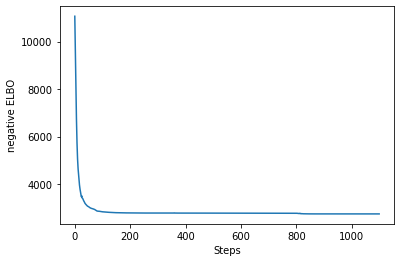

In [12]:
# kernel parameters
ell = 0.5  # the length scale
sigma_squared = 3.0**2  # the kernel variance
Z, m_qv, L_qv, neg_elbo_values = optimize_elbo(ell, sigma_squared, optimize_inducing_points=True)
plt.plot(neg_elbo_values)
plt.ylabel('negative ELBO')
plt.xlabel('Steps')
plt.show()

(10000, 2)
(5300, 2)
(16, 1)
(16, 16)


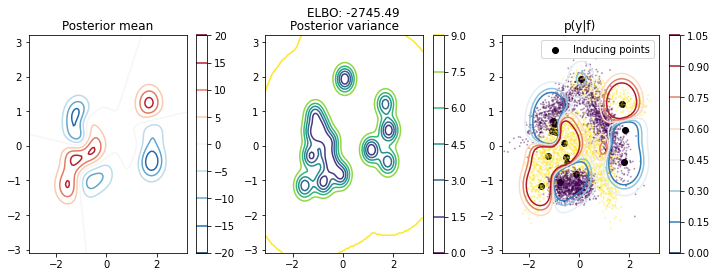

In [13]:
###############################################
# ------- insert code here -------------------
###############################################
# Note: The m_qv and L_qv are whitened posterior parameters

# Log-hyperparameters:
v_log_ell = tf.Variable(np.log(ell), dtype=tf.float64)
v_log_sigma_squared = tf.Variable(np.log(sigma_squared), dtype=tf.float64)

M = 16
Z = tf.Variable(X[:M].copy())

# The prior mean at the inducing points and the Cholesky factor of the prior covariance, with small diagonal jitter
K_p = kernelmatrix(Z, Z, v_log_ell, v_log_sigma_squared) + 1e-10*np.eye(M)
m_p = tf.zeros((M, 1), dtype=tf.float64)
L_p = tf.linalg.cholesky(K_p)

print(Xnew.shape)
print(X.shape)
print(m_qu.shape)
print(L_qu.shape)
m_qu, L_qu = unwhiten(m_p, L_p, m_qv, L_qv)
m_new, v_new = posterior_marginal_prediction(Xnew, Z, m_qu, L_qu, v_log_ell, v_log_sigma_squared)

plot_posterior(Z, m_new, v_new, neg_elbo_values)

Answer: the result is significantly better when the inducing points are also optimized, as the ELBO magnitude for inducing point optimization is twice smaller than the ELBO without inducing point optimization. 

### Advanced extra questions on variational inference, VGPs and sparse VGPs (only for the curious, no extra points!)
* For fixed hyperparameters, does the ELBO match the marginal likelihood $\log p({\bf y})$? If so, why & when?
* How does the ELBO-at-optimum change as you vary the number of inducing points?
* Repeat the procedure for the regression setting with Gaussian noise. You need to derive new variational expectations since the likelihood changes. Apply the resulting algorithm to the regression problem of the previous assignment.
* Jointly optimise the kernel hyperparameters in addition to the inducing points $Z$, and $q({\bf u})$. How does the optimal value of the kernel hyperparameters depend on the number of inducing points?

## Task 2: Reproducing kernel Hilbert spaces \& Representer Theorem (2 points)

### Task 2.1: Uniqueness of $k$ for a given RKHS

Recall: Given a kernel $k$ there exists a unique RKHS, and given a RKHS there exists a unique kernel $k$.

Show that given a RKHS there exists a unique kernel $k$.

1. Start with the assumption that there exist more than one kernel, i.e., $k_1$ and $k_2$.
2. Now use the reproducing property of $k_1$ and $k_2$ to show that for any function $f$, the difference between $\langle f,k_1 - k_2 \rangle$ is zero, hence, the kernels are the same.

 $$ \langle f, k_1 - k_2 \rangle = \dots $$

Answer

Given a kernel $k$ there exists a unique RKHS (Reproducing kernel Hilbert space), and given a RKHS there exists a unique kernel $k$. This statement is also known as the Moore-Aronszajn theorem, which states that every symmetric, positive definite kernel defines a unique reproducing kernel Hilbert space. A Hilbert space is an inner product space that is complete with respect to the norm defined by the inner product. Now we need to prove that given a RKHS there exists a unique kernel $k$

Let $(\mathcal{H},\langle \cdot , \cdot \rangle \mathcal{H})$ be a Hilbert space of real-valued functions on X. A real-valued function $k$ on $\mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R} $
 is a reproducing kernel of $\mathcal{H}$ if and only if 
 
1. $\forall x \in \mathcal{X}$, $k_x(y) = k(x,y) \in \mathcal{H}$ as a function of $y \in \mathcal{X}$;
2. $\forall x \in \mathcal{X}, \forall f \in \mathcal{H}, \langle f,K(x,⋅) \rangle_\mathcal{H} = f(x) \text{ (reproducing property)}$. In particular, it is $\langle k_x,f \rangle = \langle k_x, \sum_i \alpha_i k_{x_i} \rangle = \sum_i \alpha_i \langle k_x, k_{x_i} \rangle = \sum_i \alpha_i k(x, x_i) = f(x)$

Note that the reproducing property of $K$ implies that $\langle K(x,\cdot), K(x′,\cdot) \rangle_{\mathcal{H}}=K(x,x′)$



1. We assume that there exist more than one kernel, i.e., $k_1$ and $k_2$ associated with the same RKHS
2. Reproducing property

Because the RKHS $\mathcal{H}$ is induced by $k_1$ => we have $k_1(x, f) = \langle f, k_{1x} \rangle$, where $k_{1x}(y) = k_1(x, y)$.

Alsom the same RKHS is also induced by $k_2$ => we have $k_2(x, f) = \langle f, k_{2x} \rangle$, where $k_{2x}(y) = k_2(x, y)$

Now, given the function $f = k_{1x} - k_{2x}$ as the difference between the two kernels, we can apply the inner product linearity and the reproducing property of $k_1$ and $k_2$

\begin{align*}
\langle f, k_1 - k_2 \rangle = \langle k_{1x} - k_{2x}, k_1 - k_2 \rangle \
= \langle k_{1x}, k_1 - k_2 \rangle - \langle k_{2x}, k_1 - k_2 \rangle \
= k_1(x,x) - k_2(x,x) \
= 0
\end{align*}

Therefore, this means that $\langle f, k_1 - k_2 \rangle = 0$ for all $f \in \mathcal{H}$ and $x \in X$. Because of the uniqueness of the reproducing kernel, it must be true that $k_1 = k_2$, which concludes the theorem that there is only one unique kernel $k$ that reproduces the RKHS $\mathcal{H}$.

Model solution

\begin{align*}
\langle f, k_1 - k_2 \rangle = \langle k_{1x} - k_{2x}, k_1 - k_2 \rangle \
= \langle k_{1x}, k_1 - k_2 \rangle - \langle k_{2x}, k_1 - k_2 \rangle \
= k_1(x,x) - k_2(x,x) \
= 0
\end{align*}

### Task 2.2: Kernel ridge regression

The aim of this task is to compute the solution to the Kernel ridge regression problem using `scipy.optimize` and compare it to the analytical solution.

1. Compute the kernel matrix using a squared exponential kernel function

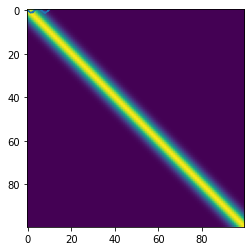

In [14]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt
%matplotlib inline

# toy data
n = 100
x = np.linspace(0,10,n).reshape((n,1))
y = np.sin(x)
y = y.reshape(-1) + 0.1*np.random.randn(n)

plt.plot(x,y)

# Code goes here...
def kernelmatrix_np(X1, X2, ell, sigma_squared):
    dist = np.sum((X1[:,None] - X2) **2, axis=2)
    kernel_matrix = sigma_squared * np.exp(-dist / (ell**2))
    return kernel_matrix

K = kernelmatrix_np(x, x, 0.5, 3**2)

plt.imshow(K)

2. Implement the objective of Kernel ridge regression in the function below. (See slides Eq. 16 - 17)

In [15]:
# lambda
lam = 2

def ridge_obj(alpha):
    # slide 11 lecture 8
    J_alpha = alpha.T @ (K @ K.T + lam * K) @ alpha - 2 * y.T @ K @ alpha 
    return J_alpha # Code goes here

Minimize the objective

In [16]:
r = minimize(ridge_obj, np.random.rand(n))

3. Test for convergence.

In [17]:
alpha_analytic = np.linalg.inv(K + lam * np.eye(K.shape[0])) @ y
alpha_analytic = alpha_analytic.flatten()
alpha_numeric = np.array(r.x).flatten()

print(r.success)
print(r.status)
print(r.x.shape)
print(r.x)

print("\nThe difference norm between the analytic and numeric solution (should be smaller than 3)")
print(np.linalg.norm(alpha_analytic - alpha_numeric))

True
0
(100,)
[ 0.02617321  0.00829478 -0.04779128 -0.04054867  0.06350837 -0.01854014
  0.12891262 -0.19464004  0.17394002 -0.19807341  0.35646468 -0.36964204
  0.27037053 -0.06477192  0.06365561 -0.01570974 -0.18674693  0.42329271
 -0.3089339   0.05123293 -0.02089152  0.21688256 -0.13157962 -0.07808221
  0.31320995 -0.33793072  0.16671184  0.00961724 -0.0190115  -0.05933063
  0.06070662  0.07353686 -0.16513153  0.20351616 -0.20378911  0.08726522
 -0.00245985 -0.07430246  0.08970061 -0.0926745   0.08540055 -0.0677973
 -0.04135846 -0.0272221   0.09133061 -0.08503626 -0.0414947  -0.03164133
  0.15507182 -0.11692505 -0.17309769  0.26263702 -0.08263779 -0.24746303
  0.27709596 -0.16874639  0.13784488 -0.15545053 -0.05638262  0.34948141
 -0.38785002  0.08100708  0.18058988 -0.16391848  0.02852728  0.07478688
 -0.09150694  0.10565651 -0.13877852  0.16742152 -0.11460415  0.09553437
  0.05276336 -0.05909267 -0.06939062  0.24593164 -0.2541801   0.06638187
  0.17916751 -0.08274553  0.04315458 -

4. Implement the function called `plot_ridge` that plots the solution obtained through `scipy.optimize` and compares to the analytical solution.

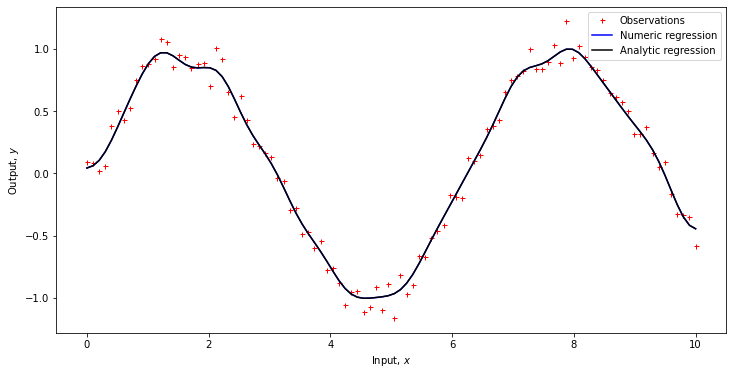

In [18]:
# Helper function for plotting results
def plot_ridge(x, y):
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, 'r+', markersize=5, label=u'Observations')
    
    x_flat = x.flatten()
    alpha_analytic = np.linalg.inv(K + lam * np.eye(K.shape[0])) @ y
    alpha_analytic = alpha_analytic.flatten()
    alpha_numeric = np.array(r.x).flatten()
    # Code goes here...    
    regression_numeric = K.T @ alpha_numeric
    regression_analytic = K.T @ alpha_analytic
    plt.plot(x, regression_numeric, 'b', label='Numeric regression')
    plt.plot(x, regression_analytic, 'k', label='Analytic regression')
    
    plt.xlabel('Input, $x$')
    plt.ylabel('Output, $y$')
    plt.legend()
    
plot_ridge(x, y)

## Task 3: Infinitely wide single-hidden layer neural networks (2 points)

### Task 3.1: Covariance of a single-hidden layer BNN

One of the classic examples of for single-hidden layer BNNs is the case of squared exponential activation function.
In this case, the activation function is defined as:

$$ \sigma(x) = \exp(-(x-u)^2 / 2\sigma^2_g) $$ 
where $u \sim \mathtt{N}(0, \sigma^2_u)$ and $\sigma^2_g$ is a hyperparameter. Implement the kernel function corresponding to the infinite width limit. (see Rasmussen and Williams book Section 4.2). You can leave out the $(\frac{\sigma_e}{\sigma_u})^d$ constant term, since that can always be balanced with a constant scaling term in the original activation function. 

In [19]:
def kernel(x, sigma_g, sigma_u):
    # Code goes here
    # equation 4.30 in the book
    # MODEL SOLUTION
    sigma_s = 2 * sigma_g ** 2 + (sigma_g ** 4/sigma_u ** 2)
    sigma_m = 2 * sigma_u ** 2 + sigma_g ** 2
    sigma_e = (2/sigma_g ** 2 + 1/sigma_u ** 2) ** (-1/2)
    
    xx, xy = np.meshgrid(x,x)
    D = (xx - xy) ** 2
    # term1 = (sigma_e/sigma_u) ** len(x) # <- constant scaling term
    term2 = np.exp(-(x**2)/(sigma_m * 2))
    term3 = np.exp(-D/(sigma_s * 2))
    term4 = np.transpose(np.exp(-(x**2)/(sigma_m * 2)))
    K = term2 * term3 * term4
    return K

Generate some more toy data

In [20]:
# toy data
n = 100
x = np.linspace(-4,4,n).reshape((n,1))
y = np.sin(x)
y = y.reshape(-1) + 0.1*np.random.randn(n)

2. Visualize the kernel matrix for $\sigma_g = 1$ and $\sigma_u = 1$

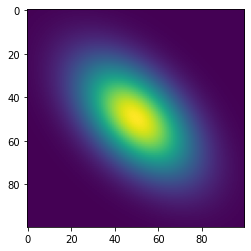

In [21]:
# Solution
plt.imshow(kernel(x, 1, 1))

3. Plot the Kernel ridge regression solution for different settings of $\sigma_u$, e.g. $1, 2.5, 5$. 
4. What can be observed when changing $\sigma_u$?
5. What happens if $\sigma_u \to \infty$?

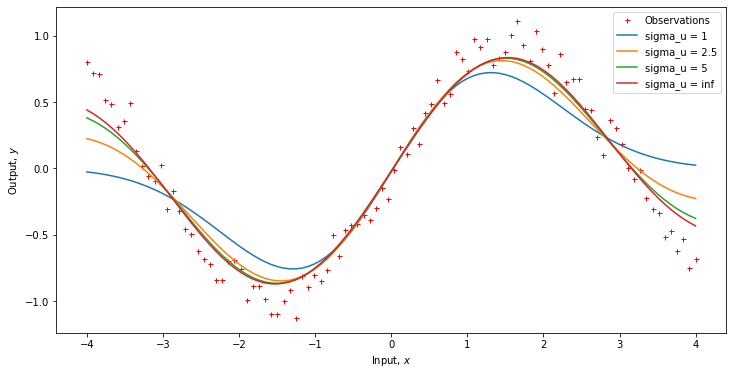

In [22]:
n, d = x.shape

K = kernelmatrix_np(x, x, 0.5, 3**2)

plt.figure(figsize=(12, 6))
plt.plot(x, y, 'r+', markersize=5, label=u'Observations')

# Code goes here...
K = kernelmatrix_np(x, x, 0.5, 3**2)

alpha = np.linalg.inv(K + lam * np.eye(K.shape[0])) @ y

lam = 2

K1 = kernel(x, 1, 1)
alpha1 = np.linalg.inv(K1 + lam * np.eye(K1.shape[0])) @ y
y_pred1 = K1.T @ alpha1

K2 = kernel(x, 1, 2.5)
alpha2 = np.linalg.inv(K2 + lam * np.eye(K2.shape[0])) @ y
y_pred2 = K2.T @ alpha2

K3 = kernel(x, 1, 5)
alpha3 = np.linalg.inv(K3 + lam * np.eye(K3.shape[0])) @ y
y_pred3 = K3.T @ alpha3

Kinf = kernel(x, 1, 10e30)
alpha_inf = np.linalg.inv(Kinf + lam * np.eye(Kinf.shape[0])) @ y
y_pred_inf = Kinf.T @ alpha_inf

plt.plot(x, y_pred1, label='sigma_u = 1')
plt.plot(x, y_pred2, label='sigma_u = 2.5')
plt.plot(x, y_pred3, label='sigma_u = 5')
plt.plot(x, y_pred_inf, label='sigma_u = inf')

plt.xlabel('Input, $x$')
plt.ylabel('Output, $y$')
plt.legend()

4. When changing $\sigma_u$, we can see that the uncertainty in the regression will vary significantly, with low values of $\sigma_u$ signifying more general fitting (high bias) while higher values signifying more specific fitting (high variance). 

5. When $\sigma_u \to \infty$, it will closely fit the data as it has least uncertainty. This is in contrast to low $sigma_u$ values where the uncertainties are much greater. 

### Task 3.2: Neural Tangent Kernel

Recall: In the lecture we discussed the NTK derived for the following single-hidden layer neural network:

$$ f(x; \theta) = \frac{1}{\sqrt{K}} \sum^{K}_{j=1} w^{[1]}_{j} \, \sigma\left( w^{[0]}_{j} \, x \right) $$

The NTK was defined as the kernel function:

$$ k(x,y) = \langle \nabla_\theta f(x; \theta), \nabla_\theta f(x; \theta) \rangle $$

1. Calculate the gradients of $f$ wrt $w_j^{[1]}$ and wrt $w_j^{[0]}$.

$$ \nabla_{w^{[1]}_j} f(x; \theta) = \dots $$

$$ \nabla_{w^{[0]}_j} f(x; \theta) = \dots $$

2. Calulate the kernel functions (Note: Compute $k^{[1]}(x, y)$ for each $j$ and sum them up)

$$ k^{[1]}(x, y) = <\nabla_{w^{[1]}} f(x; \theta), \nabla_{w^{[1]}} f(y; \theta)> $$

$$ k^{[0]}(x, y) = <\nabla_{w^{[0]}} f(x; \theta), \nabla_{w^{[0]}} f(y; \theta)> $$

$$ k^{[1]}(x, y) = \dots $$

$$ k^{[0]}(x, y) = \dots $$

3. Observe that the kernel function changes for different values of the parameters. What do you expect to happen if $K \to \infty$, assuming that the weights $w^{[0]}_{j}$ and $w^{[1]}_{j}$ are initialized to independent and identically distributed values (as is usually done)? Does $k^{[1]}$ still depend on a specific choice of values for $w^{[0]}_j$?

(Hint: Use the law of large numbers and assumption that all parameters are iid. No derivations required.)

Answer:

1. Calculate the gradients of $f$ wrt $w_j^{[1]}$ and wrt $w_j^{[0]}$.

$$ \nabla_{w^{[1]}_j} f(x; \theta) = \frac{1}{\sqrt{K}} \, \sigma\left( w^{[0]}_{j} \, x \right) $$

$$ \nabla_{w^{[0]}_j} f(x; \theta) = \frac{1}{\sqrt{K}} w^{[1]}_{j} \, \sigma'\left( w^{[0]}_{j} \,  x \right) x $$

2. Calulate the kernel functions (Note: Compute $k^{[1]}(x, y)$ for each $j$ and sum them up)

$$ k^{[1]}(x, y) = <\nabla_{w^{[1]}} f(x; \theta), \nabla_{w^{[1]}} f(y; \theta)> $$

$$ k^{[0]}(x, y) = <\nabla_{w^{[0]}} f(x; \theta), \nabla_{w^{[0]}} f(y; \theta)> $$

$$ k^{[1]}(x, y) = \dfrac{1}{K} \sum^K_{j=1} 
\sigma\left(x^T w^{[0]}_{j} \, \right)  
\sigma\left(y^T w^{[0]}_{j} \, \right)  $$

$$ k^{[0]}(x, y) = \dfrac{1}{K} \sum^K_{j=1} (w^{[1]}_{j})^2 
\sigma'\left( w^{[0]}_{j} x \,  \right) 
\sigma'\left( w^{[0]}_{j} y \,  \right) 
(x y) $$

3. Observe that the kernel function changes for different values of the parameters. What do you expect to happen if $K \to \infty$, assuming that the weights $w^{[0]}_{j}$ and $w^{[1]}_{j}$ are initialized to independent and identically distributed values (as is usually done)? Does $k^{[1]}$ still depend on a specific choice of values for $w^{[0]}_j$?


A Gaussian process (GP) is a collection of random variables $\mathbf{F}$ indexed by $\mathcal{X}$, where any finite subset of $\mathbf{F}$ is joint multivariate Gaussian distributed, and of which any two overlapping finite sets are marginally consistent.

⇒ A single-hidden layer of neural tangent network converges to a GP when $K \rightarrow \infty$. 

As a result, $k^{[1]}$ does not depend on a specific choice of values for $w^{[0]}_j$ when $K \rightarrow \infty$